## From handbook

In [2]:
import numpy as np
from sklearn.model_selection import train_test_split

X, y = np.arange(1000).reshape((500, 2)),  np.arange(500)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

Plotting Learning Curves and Checking Models’ Scalability


In [3]:
from sklearn.datasets import load_digits
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

X, y = load_digits(return_X_y=True)
nb = GaussianNB()
svc = SVC(kernel='rbf', gamma=0.001)

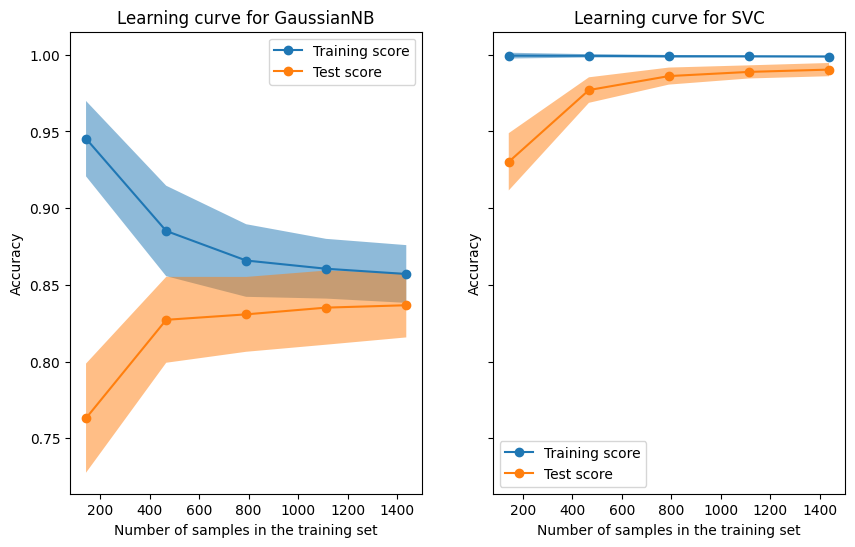

In [14]:
import matplotlib.pyplot as plt
from sklearn.model_selection import LearningCurveDisplay, ShuffleSplit

fig, axs = plt.subplots(1, 2, figsize=(10, 6), sharey=True)
common_params = {
    "X": X,
    "y": y,
    "train_sizes": np.linspace(0.1, 1.0, 5),
    "cv": ShuffleSplit(n_splits=50, test_size=0.2, random_state=42),
    "score_type": "both",
    "n_jobs": 4,
    "line_kw": {"marker": "o"},
    "std_display_style": "fill_between",
    "score_name": "Accuracy",
}

for ax_idx, estimator in enumerate([nb, svc]):
    LearningCurveDisplay.from_estimator(estimator, **common_params, ax=axs[ax_idx])
    handles, label = axs[ax_idx].get_legend_handles_labels()
    axs[ax_idx].legend(handles[:2], ["Training score", "Test score"])
    axs[ax_idx].set_title(f"Learning curve for {estimator.__class__.__name__}")

In [16]:
from sklearn.model_selection import KFold

X = np.array([[1, 2, 3], [4, 5, 6], [7, 8, 9], [10, 11, 12]])
y = np.array([1, 2, 3, 4])

kf = KFold(n_splits=2)

for train_index, test_index in kf.split(X):
    print("TRAIN", train_index, "TEST:", test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

TRAIN [2 3] TEST: [0 1]
TRAIN [0 1] TEST: [2 3]


In [18]:
from sklearn.model_selection import cross_val_score
X, y = load_digits(return_X_y=True)
svc = SVC(kernel='linear', C=1, random_state=42)
scores = cross_val_score(svc, X, y, cv=5)
print(scores)

[0.96388889 0.91944444 0.96657382 0.9637883  0.92479109]


In [24]:
from sklearn.model_selection import LeaveOneOut
X = np.array([[1, 2], [3, 4], [5, 6]])
y = np.array([1, 2, 3])
loo = LeaveOneOut()

for train_index, test_index in loo.split(X):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

TRAIN: [1 2] TEST: [0]
TRAIN: [0 2] TEST: [1]
TRAIN: [0 1] TEST: [2]


In [ ]:
from sklearn.model_selection import StratifiedKFold

X = np.array([[1, 2], [3, 4], [1, 2], [3, 4], [1, 3], [0, 0], [1, 11]])
y = np.array([0, 1, 1, 1, 1, 1, 0])

skf = StratifiedKFold(n_splits=2)

for train_index, test_index in skf.split(X,y):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

TRAIN: [4 5 6] TEST: [0 1 2 3]
TRAIN: [0 1 2 3] TEST: [4 5 6]


## Practice

Implement KFold from skratch

In [103]:
class MyKFold():
    def __init__(self, n_splits=5, shuffle=False, random_state=None):
        self.n_splits=n_splits
        self.shuffle = shuffle
        self.rng = np.random.default_rng(seed=random_state)        
        
    
    def split(self, X):
        n_samples = X.shape[0]
        indices = np.arange(n_samples)
        indices_shuffled = indices.copy()
        if self.shuffle:                        
            self.rng.shuffle(indices_shuffled)

        folds = []        
        fold_sizes = np.full(self.n_splits, n_samples // self.n_splits, dtype=int) 
        fold_sizes[:(n_samples % self.n_splits)] += 1 #равномерно распределяем остаток

        current=0

        for fold_size in fold_sizes:
            start = current
            end = current + fold_size
            folds.append(indices_shuffled[start:end])
            current = end

        splits = []  
        
        for i in range(self.n_splits):
            test_indices = folds[i]
            train_indices_mask = np.ones(n_samples, dtype=bool)
            train_indices_mask[test_indices] = False
            train_indices = indices[train_indices_mask]
            splits.append((train_indices, test_indices))
        return splits


X = np.array([[1, 2, 3], [4, 5, 6], [7, 8, 9], [10, 11, 12], [3, 3, 2]])
y = np.array([0, 1, 1, 0, 1])

my_kf = MyKFold(n_splits=2, shuffle=True, random_state=42)

for train_index, test_index in my_kf.split(X):
    print("TRAIN", train_index, "TEST:", test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]


TRAIN [0 1] TEST: [4 2 3]
TRAIN [2 3 4] TEST: [1 0]


Implement StratifiedKFold 

In [106]:
class MyStratifiedKFold(MyKFold):
    def split(self, X, y):    
        n_samples = X.shape[0]
        indices = np.arange(n_samples)
        indices_shuffled = indices.copy()

        if self.shuffle:            
            self.rng.shuffle(indices_shuffled)            

        if not isinstance(y, np.ndarray):
            y = np.array(y)
        classes, y_indices = np.unique(y, return_inverse=True)        
        n_classes = len(classes)                        
        class_indices = [indices_shuffled[y_indices == i] for i in range(n_classes)]                        

        if self.shuffle:
            for i in range(n_classes):
                self.rng.shuffle(class_indices[i])            
        
        class_fold_sizes = []
        for i in range(n_classes):
            n_class_samples = len(class_indices[i])
            fold_sizes = np.full(self.n_splits, n_class_samples // self.n_splits)
            fold_sizes[:n_class_samples % self.n_splits] += 1
            class_fold_sizes.append(fold_sizes)
        
        test_folds_indices = [[] for _ in range(self.n_splits)]
        current_class_positions = np.zeros(n_classes, dtype=int)

        for i in range(self.n_splits):
            for j in range(n_classes):
                start = current_class_positions[j]    
                end = start + class_fold_sizes[j][i]
                test_folds_indices[i].extend(class_indices[j][start:end])
                current_class_positions[j] = end
            np.random.shuffle(test_folds_indices[i])
        

        splits = []
        
        for i in range(self.n_splits):
            test_fold = test_folds_indices[i]            
            train_fold_mask = np.ones(n_samples, dtype=bool)            
            train_fold_mask[test_fold] = False                                    
            train_fold = indices[train_fold_mask]        
            splits.append((train_fold, test_fold))

        return splits


X = np.array([[1, 2, 3], [4, 5, 6], [7, 8, 9], [10, 11, 12], [3, 3, 2]])
y = np.array([-1, 1, 1, -1, 1])

my_skf = MyStratifiedKFold(2,True,42)    
for train_index, test_index in my_skf.split(X, y):
    print("TRAIN", train_index, "TEST:", test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

TRAIN [0 4] TEST: [2, 1, 3]
TRAIN [1 2 3] TEST: [4, 0]


In [115]:
import scipy
from sklearn.datasets import load_breast_cancer
from sklearn.ensemble import RandomForestClassifier

k = 5
X, y = load_breast_cancer(return_X_y=True)
my_kf = KFold(n_splits=k,shuffle=True, random_state=42)
estimators = []
estimators_results = [] # for simplicity it will be accuracy
for train_index, test_index in my_kf.split(X):
    print("TRAIN", train_index.shape, "TEST:", test_index.shape)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    rfc = RandomForestClassifier()
    rfc.fit(X_train, y_train)
    estimators.append(rfc)    
    estimators_results.append(rfc.score(X_test, y_test))

print("results", estimators_results)
mean_result = np.mean(estimators_results)
print('mean', mean_result)
std_result = np.std(estimators_results)
print('std', std_result)
confidence_level = 0.95
alpha = 1 - confidence_level
se_result = std_result / pow(k, 0.5)
df_result = k - 1

critical_t_value = scipy.stats.t.ppf(1 - (alpha / 2), df_result)
me_result = critical_t_value * se_result
ci_result = [mean_result - me_result, mean_result + me_result]
print('confidence interval', ci_result)

TRAIN (455,) TEST: (114,)
TRAIN (455,) TEST: (114,)
TRAIN (455,) TEST: (114,)
TRAIN (455,) TEST: (114,)
TRAIN (456,) TEST: (113,)
results [0.9649122807017544, 0.9824561403508771, 0.9385964912280702, 0.956140350877193, 0.9557522123893806]
mean 0.9595714951094549
std 0.014272641224603165
confidence interval [0.9418496703415863, 0.9772933198773236]
